# Cardiovascular Risk Prediction in Cleveland Population: A Predictive Analysis of Heart Disease Occurrence

## Introduction

Coronary diseases pose significant challenges to everyday wellbeing, requiring precise predictive models where understanding diagnostic factors is crucial. Utilizing a dataset of clinical test results and cardiovascular diagnosis, this analysis focuses on the relationship between age, maximum heart rate, and diagnosis levels in Cleveland. The unique healthcare landscape and lifestyle factors make this exploration essential for tailored interventions and improved cardiovascular risk assessment in the Cleveland population. Thus, this project will explore the following: Can maximum heart rate and age be used to predict heart disease in Clevelanders?

This analysis' heart disease dataset is from a database created to test a discriminant function model (Detrano, 1989), developed using clinical and noninvasive test results from patients undergoing angiography. Collected from groups in Hungary, Switzerland, Long Beach, and Cleveland, the database encompasses variables including demographics, chest pain, resting blood pressure, cholesterol levels, maximum heart rate and other relevant features for diagnosis. The proposed model focuses on the dataset of 303 Cleveland Clinic patients. 

## Methods and Results

In [1]:
# load all necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Preliminary analysis

In [2]:
# downloading and reading data, naming columns
url <- "https://raw.githubusercontent.com/ssun05/dsci_100_002_group5_project/main/processed.cleveland.data"
heart_data <- read_csv(url, col_names = c("age", "sex", "chest_pain", "trestbps", "chol", "fasting_bld_sgar",
                                                      "restecg", "max_heart_rate", "exerc_angina", "oldpeak", "slope", "ca", "thal", "diagnosis"))
print("Table 1: Full Heart Dataset")
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fasting_bld_sgar, restecg, m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Full Heart Dataset"


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [3]:
# filter for males and reclass diagnosis as factor, make labels understandable
heart_data_renamed <- heart_data |> 
                    mutate(diagnosis = as_factor(diagnosis)) |>
                    mutate(diagnosis = fct_recode(diagnosis, "no" = "0", "yes" = "1", "yes" = "2", "yes" = "3", "yes" = "4"))

print("Table 2: Heart Dataset - Males only")
heart_data_renamed

[1] "Table 2: Heart Dataset - Males only"


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,no


In [4]:
set.seed(1234)
heart_split <- initial_split(heart_data_renamed, prop = 0.75, strata = diagnosis)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [5]:
# table of diagnosis counts
label_counts <- heart_train |>
                group_by(diagnosis) |>
                summarize(count = n())
print("Table 3: Diagnosis Class Counts")
label_counts

missing_data <- heart_train |> 
                filter(age == NA | max_heart_rate == NA | diagnosis == NA |
                       age == "?" | max_heart_rate == "?" | diagnosis == "?") |>
                    summarize(missing_data = n())

print("Table 4: Missing Data Count")
missing_data

[1] "Table 3: Diagnosis Class Counts"


diagnosis,count
<fct>,<int>
no,123
yes,104


[1] "Table 4: Missing Data Count"


missing_data
<int>
0


[1] "Table 5: Mean Heart Rates per Heart Disease Diagnoses"


diagnosis,mean_heart
<fct>,<dbl>
no,157.4797
yes,139.0673


[1] "Figure 1: Mean Heart Rates per Heart Disease Diagnoses"


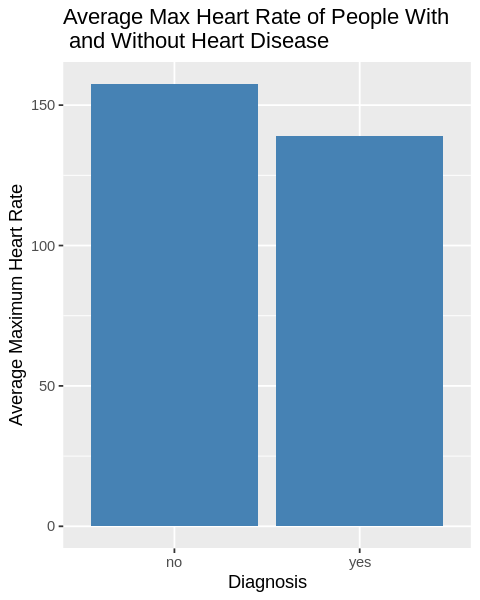

In [6]:
# predictor mean: heart rate
mean_max_hrt_rate <- heart_train |>
                        group_by(diagnosis) |>
                        summarize(mean_heart = mean(max_heart_rate))

print("Table 5: Mean Heart Rates per Heart Disease Diagnoses")
mean_max_hrt_rate

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_max_hrt_rate |> 
                ggplot(aes(x = diagnosis, y = mean_heart)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Maximum Heart Rate") +
                ggtitle("Average Max Heart Rate of People With \n and Without Heart Disease")

print("Figure 1: Mean Heart Rates per Heart Disease Diagnoses")
avg_hrt_plot

[1] "Table 6: Mean Ages per Heart Disease Diagnoses"


diagnosis,mean_age
<fct>,<dbl>
no,52.48780
yes,56.94231


[1] "Figure 2: Mean Ages per Heart Disease Diagnoses"


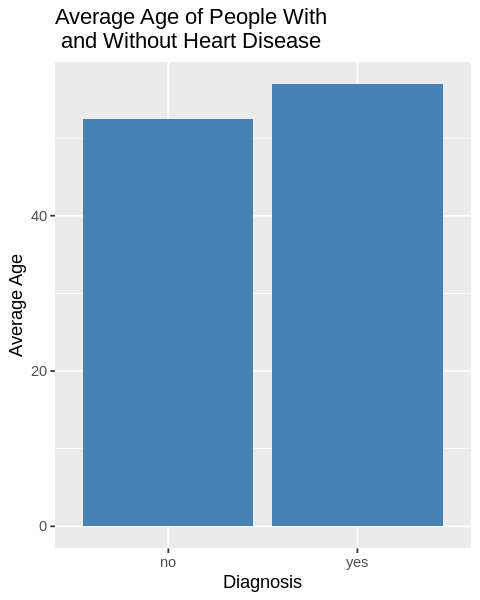

In [7]:
# predictor mean: age
mean_age <- heart_train |>
                group_by(diagnosis) |>
                summarize(mean_age = mean(age))

print("Table 6: Mean Ages per Heart Disease Diagnoses")
mean_age

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_age |> 
                ggplot(aes(x = diagnosis, y = mean_age)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Age") +
                ggtitle("Average Age of People With \n and Without Heart Disease")

print("Figure 2: Mean Ages per Heart Disease Diagnoses")
avg_hrt_plot

[1] "Figure 3: Scatterplot of Max Heart Rate and Age per Heart Disease Diagnosis"


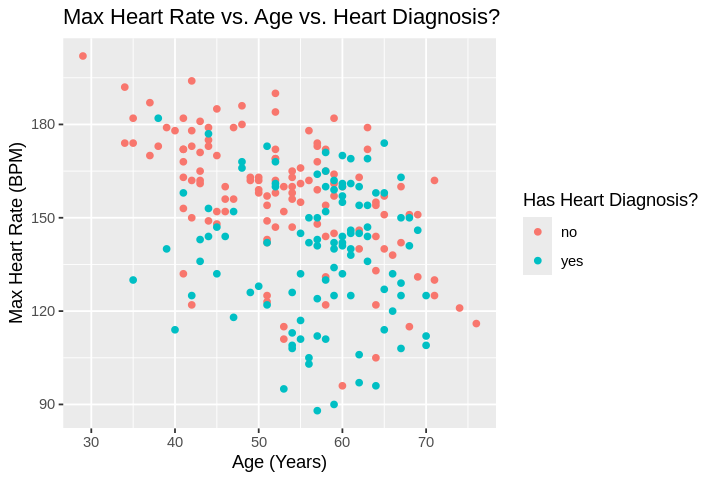

In [8]:
options(repr.plot.width = 6, repr.plot.height = 4)

heart_plot <- heart_train|> 
                ggplot(aes(x = age, y = max_heart_rate, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Max Heart Rate (BPM)",
                     color = "Has Heart Diagnosis?",
                     title = "Max Heart Rate vs. Age vs. Heart Diagnosis?")

print("Figure 3: Scatterplot of Max Heart Rate and Age per Heart Disease Diagnosis")
heart_plot

[1] "Figure 4: Distribution of Age per Heart Disease Diagnosis"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


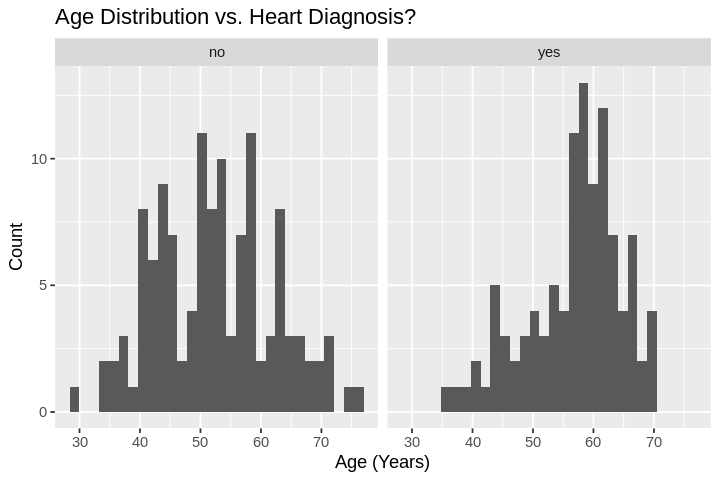

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)

age_distribution <- heart_train|> 
                ggplot(aes(x = age)) +
                geom_histogram() +
                labs(x = "Age (Years)",
                     y = "Count",
                     title = "Age Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

print("Figure 4: Distribution of Age per Heart Disease Diagnosis")
age_distribution

[1] "Figure 5: Distribution of Max Heart Rate per Heart Disease Diagnosis"


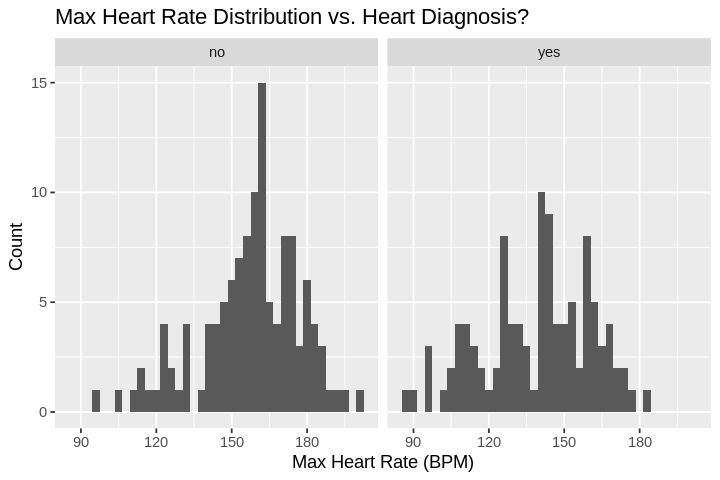

In [10]:
max_distribution <- heart_train|> 
                ggplot(aes(x = max_heart_rate)) +
                geom_histogram(binwidth = 3) +
                labs(x = "Max Heart Rate (BPM)",
                     y = "Count",
                     title = "Max Heart Rate Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

print("Figure 5: Distribution of Max Heart Rate per Heart Disease Diagnosis")
max_distribution

### Methods

We will answer the research question using a knn classification model with "age" and "max_heart_rate" variables as predictors, and the presence of a diagnosis as the class label. After repeated testing we found that age and max heart rate allows for the most predictive power in this application.

"Age" represents the age of a patient at the time of data collection. "max_heart_rate" is also known as *thalach*, and represents a patient's max heart rate achieved. 

We decided to use knn classification instead of knn regression due to the nature of the question we are trying to answer. Diagnosis takes on values from 0 - 4 which appears quantitative, but is more categorical in nature because each value represents a category of heart disease severity. In order to make this distinction clearer we decided to categorize these values into two: "no" (0) and "yes" (1 - 4) which simply indicates the presence of heart disease or not.

We will perform cross-validation to optimize a k-value based on accuracy. 

Finally to build our classifier we will create an workflow that contains a recipe that scales and centers all predictors, and KNN classification spec. model with our determined k value.

We will visualize our results with a confusion matrix summarizing the observations and our classifier's predictions. We will check training model accuracy with cross validation, and evaluate the quality of the model based on recall. We want to ensure maximum people with heart disease is correctly identified, minimizing false negatives. 

Finally, we will check accuracy and recall of the test data. 

### Analysis

[1] "Figure 6: Graphed accuracies of k-nearest neighbours"


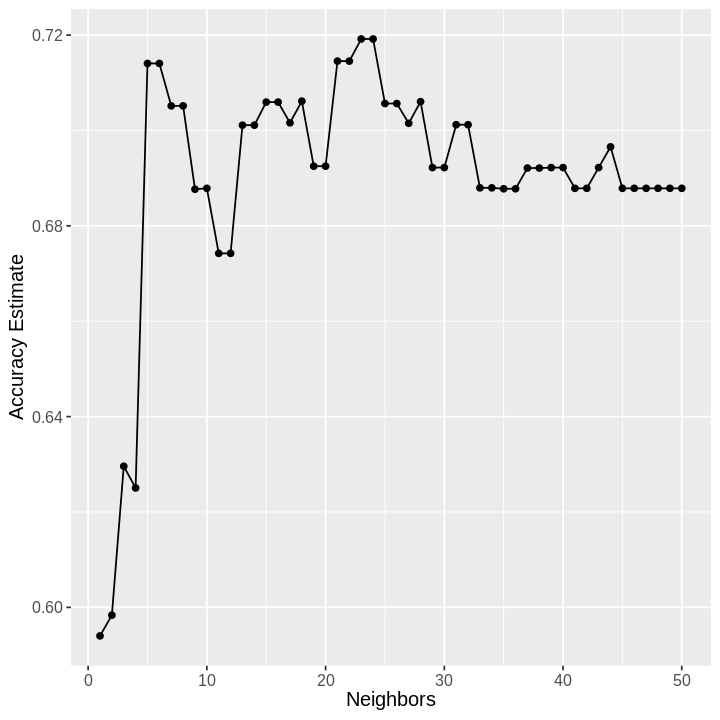

In [89]:
set.seed(9999)

options(repr.plot.height = 6, repr.plot.width = 6)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

training_recipe <- recipe(diagnosis ~ age + max_heart_rate, data = heart_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

training_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

training_fold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(training_spec) |>
  tune_grid(resamples = training_fold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_fit |>
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

print("Figure 6: Graphed accuracies of k-nearest neighbours")
cross_val_plot

best_k <- accuracies |> select(neighbors, mean) |>
            arrange(-mean) |>
            slice(1) |>
            pull(neighbors)

In [90]:
heart_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_spec

heart_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(heart_spec) |>
  fit(data = heart_train)

heart_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2951542
Best kernel: rectangular
Best k: 23

In [91]:
# check training accuracy of model with cross validation

test_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

heart_vfold_fit <- workflow() |>
                    add_recipe(training_recipe) |>
                    add_model(heart_spec) |>
                    fit_resamples(resamples = test_heart_vfold) |>
                    collect_metrics()

print("Table 8: 5-fold Validation of Predictor Model Accuracy")
heart_vfold_fit

[1] "Table 8: 5-fold Validation of Predictor Model Accuracy"


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7092227,5,0.03732080,Preprocessor1_Model1
roc_auc,binary,0.7602421,5,0.03737085,Preprocessor1_Model1


In [92]:
set.seed(9999)

heart_predictions <- predict(heart_fit, heart_test) |> 
                    bind_cols(heart_test)

print("Table 9: Test Heart Data Prediction Diagnoses")
heart_predictions

heart_metrics <- heart_predictions |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate)

print("Table 10: Accuracy of Model on Test Heart Data")
heart_metrics

heart_conf_mat <- heart_predictions |>
             conf_mat(truth = diagnosis, estimate = .pred_class)

print("Figure 7: Test Heart Data Confusion Matrix")
heart_conf_mat

[1] "Table 9: Test Heart Data Prediction Diagnoses"


.pred_class,age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
yes,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
no,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,no
no,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,yes
yes,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
no,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes


[1] "Table 10: Accuracy of Model on Test Heart Data"


.estimate
<dbl>
0.7105263


[1] "Figure 7: Test Heart Data Confusion Matrix"


          Truth
Prediction no yes
       no  30  11
       yes 11  24

In [ ]:
heart_predictions |> pull(diagnosis) |> levels()

test_recall <- heart_predictions |> recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

print("Table 11: Recall of Model on Test Heart Data")
test_recall

[1] "no"  "yes"

[1] "Table 11: Recall of Model on Test Heart Data"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6857143


## Results
This report used max heart rate (thalach) and age as predictors of heart disease. After performing an 5-fold cross-validation analysis the report found that the best K value to use was 23. The K value of 23 yielded the highest accuracy when performed on the training data. When  Our model yielded an accuracy of 69.2% on training data (Table 8). On test data, the model produced an accuracy of 71.1% (Table 10) and recall of 68.6% (Table 11)
https://wiki.cloudfactory.com/docs/mp-wiki/metrics/recall#:~:text=Interpreting%20Recall%20score,-In%20the%20Recall&text=From%20our%20experience%2C%20for%20both,score%20as%20the%20poor%20one.

## Discussion

Using max heart rate and age to create a model predicting heart disease diagnosis, the model yielded an accuracy of 71.1% and recall of 68.6% when tested on new data. This recall is close to 0.7, considered by CloudFactory (2024) to be a good recall; however, this score should be evaluated under a medical context. 

This report is significant in that medical professionals may use this information to identify high-risk individuals and tailor preventive strategies, emphasizing lifestyle modifications. Also, these findings could influence healthcare policy and interventions, directing resources and preventive measures toward populations with higher risk factors. Further research could explore which factor has more influence on heart disease, and evaluate the effectiveness of interventions based on age and maximum heart rates.

## References

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American Journal of Cardiology, 64*(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.